PROJET EXAMEN

Ce projet vise à illustrer les liens entre la théorie de l'optimisation convexe et les algorithmes
modernes utilisés en Machine Learning à grande échelle. Nous étudions successivement la mod
élisation, les méthodes de gradient déterministes et stochastiques, puis l'optimisation non lisse
via des algorithmes proximaux.
      

 preparer par DIENG BABAKAR C14050

In [1]:
#Importation des bibliothéque necessaires
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_rcv1

In [2]:
df = pd.read_csv('YearPredictionMSD.csv')



In [3]:

# ===============================
# EXERCICE 1 
# ===============================
# -------------------
# Séparer X et y
y = df.iloc[:, 0].values    # La première colonne : année
X = df.iloc[:, 1:].values   # Les colonnes suivantes : features

# Standardisation
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Sous-échantillon pour tests rapides
X_sub, _, y_sub, _ = train_test_split(X, y, train_size=5000, random_state=0)
n, d = X_sub.shape
print("Échantillon réduit : n =", n, "d =", d)


Échantillon réduit : n = 5000 d = 90


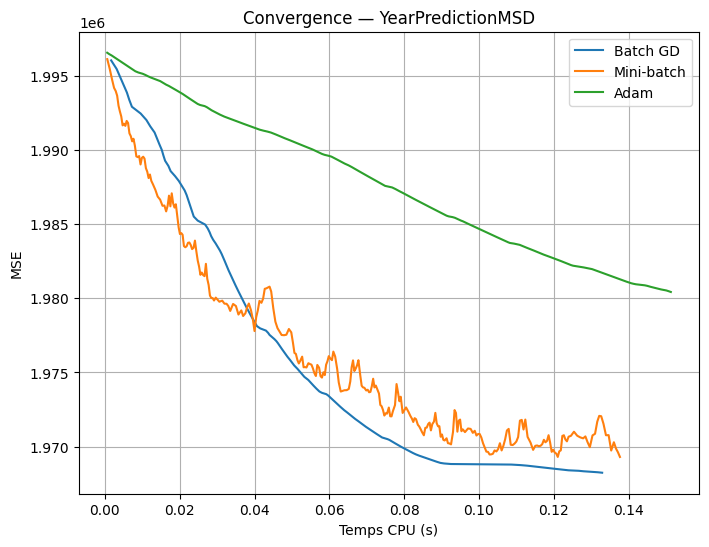

In [11]:
# ===============================
# EXERCICE 2
# ===============================
# -------------------
# MSE et gradient
# -------------------
def mse_loss(w, X, y):
    return 0.5 * np.mean((X @ w - y) ** 2)

def mse_gradient(w, X, y):
    return (X.T @ (X @ w - y)) / X.shape[0]

# -------------------
# Optimisateurs
# -------------------
def batch_gd(X, y, alpha, n_iter):
    w = np.zeros(X.shape[1])
    losses, times = [], []
    start = time.time()
    for _ in range(n_iter):
        w -= alpha * mse_gradient(w, X, y)
        losses.append(mse_loss(w, X, y))
        times.append(time.time() - start)
    return w, losses, times

def sgd(X, y, alpha0, n_iter):
    n, d = X.shape
    w = np.zeros(d)
    losses, times = [], []
    start = time.time()
    for k in range(n_iter):
        i = np.random.randint(n)
        grad = X[i] * (X[i] @ w - y[i])
        w -= (alpha0 / (1 + k)) * grad
        losses.append(mse_loss(w, X, y))
        times.append(time.time() - start)
    return w, losses, times

def minibatch_sgd(X, y, alpha, batch_size, n_iter):
    n, d = X.shape
    w = np.zeros(d)
    losses, times = [], []
    start = time.time()
    for _ in range(n_iter):
        idx = np.random.choice(n, batch_size, replace=False)
        grad = (X[idx].T @ (X[idx] @ w - y[idx])) / batch_size
        w -= alpha * grad
        losses.append(mse_loss(w, X, y))
        times.append(time.time() - start)
    return w, losses, times

def adam(X, y, alpha, beta1, beta2, eps, n_iter):
    d = X.shape[1]
    w = np.zeros(d)
    m = np.zeros(d)
    v = np.zeros(d)
    losses, times = [], []
    start = time.time()
    for k in range(1, n_iter + 1):
        grad = mse_gradient(w, X, y)
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * grad**2
        m_hat = m / (1 - beta1**k)
        v_hat = v / (1 - beta2**k)
        w -= alpha * m_hat / (np.sqrt(v_hat) + eps)
        losses.append(mse_loss(w, X, y))
        times.append(time.time() - start)
    return w, losses, times

# -------------------
# Comparaison
# -------------------
w_bg, l_bg, t_bg = batch_gd(X_sub, y_sub, 1e-2, 200)
w_sgd, l_sgd, t_sgd = sgd(X_sub, y_sub, 0.1, 300)
w_mb, l_mb, t_mb = minibatch_sgd(X_sub, y_sub, 0.01, 256, 300)
w_adam, l_adam, t_adam = adam(X_sub, y_sub, 0.05, 0.9, 0.999, 1e-8, 300)

plt.figure(figsize=(8,6))
plt.plot(t_bg, l_bg, label="Batch GD")
#plt.plot(t_sgd, l_sgd, label="SGD")
plt.plot(t_mb, l_mb, label="Mini-batch")
plt.plot(t_adam, l_adam, label="Adam")
plt.xlabel("Temps CPU (s)")
plt.ylabel("MSE")
plt.title("Convergence — YearPredictionMSD")
plt.legend()
plt.grid(True)
# plt.savefig("convergence_YearPredictionMSD.png")
# plt.close()




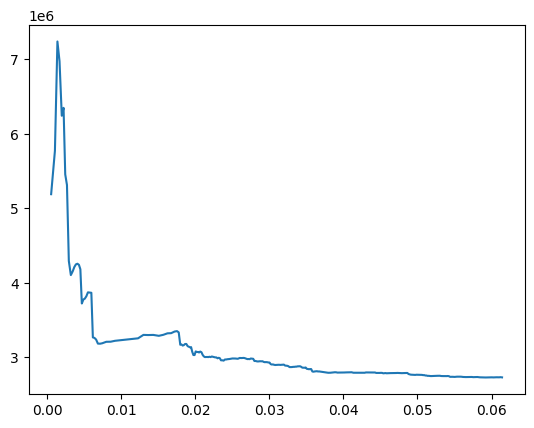

In [12]:
plt.plot(t_sgd, l_sgd, label="SGD")

Chargement RCV1...


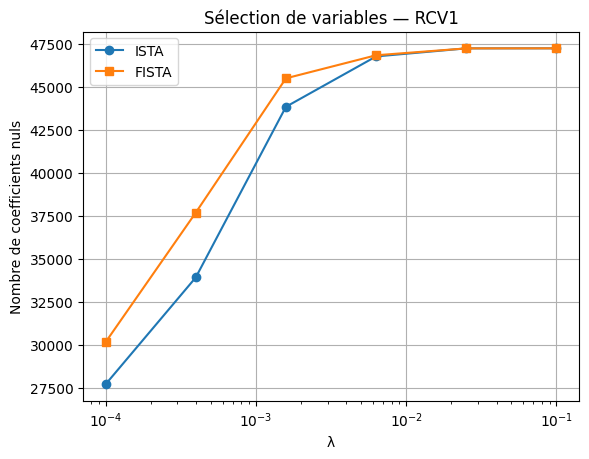

In [14]:

# ===============================
# EXERCICE 3 — RCV1 (Classification L1)
# ===============================
print("Chargement RCV1...")
X, y = fetch_rcv1(return_X_y=True)

# Binarisation pour la première catégorie
y = np.where(y[:,0].toarray() > 0, 1, -1)

# Sous-échantillon pour tests rapides
X = X[:5000].toarray()
y = y[:5000].ravel()

# Standardisation
X = StandardScaler().fit_transform(X)

# -------------------
# Logistic loss et gradient
# -------------------
def logistic_loss(w, X, y):
    z = y * (X @ w)
    return np.mean(np.log(1 + np.exp(-z)))

def logistic_gradient(w, X, y):
    z = y * (X @ w)
    sigma = 1 / (1 + np.exp(z))
    return -(X.T @ (y * sigma)) / X.shape[0]

# -------------------
# ISTA / FISTA
# -------------------
def soft_thresholding(v, lam):
    return np.sign(v) * np.maximum(np.abs(v) - lam, 0)

def ista(X, y, lam, alpha, n_iter):
    w = np.zeros(X.shape[1])
    losses = []
    for _ in range(n_iter):
        w = soft_thresholding(w - alpha * logistic_gradient(w, X, y), alpha * lam)
        losses.append(logistic_loss(w, X, y) + lam * np.linalg.norm(w, 1))
    return w, losses

def fista(X, y, lam, alpha, n_iter):
    w = np.zeros(X.shape[1])
    z = w.copy()
    t = 1
    losses = []
    for _ in range(n_iter):
        w_new = soft_thresholding(z - alpha * logistic_gradient(z, X, y), alpha * lam)
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        z = w_new + ((t - 1) / t_new) * (w_new - w)
        w, t = w_new, t_new
        losses.append(logistic_loss(w, X, y) + lam * np.linalg.norm(w, 1))
    return w, losses

# -------------------
# Sparsité vs λ
# -------------------
lambdas = np.logspace(-4, -1, 6)
zeros_ista, zeros_fista = [], []

for lam in lambdas:
    w_i, _ = ista(X, y, lam, 0.1, 100)
    w_f, _ = fista(X, y, lam, 0.1, 100)
    zeros_ista.append(np.sum(np.abs(w_i) < 1e-6))
    zeros_fista.append(np.sum(np.abs(w_f) < 1e-6))

plt.figure()
plt.semilogx(lambdas, zeros_ista, marker="o", label="ISTA")
plt.semilogx(lambdas, zeros_fista, marker="s", label="FISTA")
plt.xlabel("λ")
plt.ylabel("Nombre de coefficients nuls")
plt.title("Sélection de variables — RCV1")
plt.legend()
plt.grid(True)
# plt.savefig("sparsity_RCV1.png")
# plt.close()
